In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
import re
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, Embedding, Conv1D, GlobalMaxPooling1D,LSTM,Bidirectional,SpatialDropout1D,LayerNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
from keras import regularizers
from keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam


TF-IDF + CNN

In [2]:
# 1. Data Preprocessing
# 1.1 Load data and keep only 'text' and 'stars' columns
df = pd.read_csv('yelp.csv', usecols=['text', 'stars'])

# Convert 'stars' column: values >= 4 to 1, others to 0
df['stars'] = df['stars'].apply(lambda x: 1 if x >= 4 else 0)

# Clean the 'text' column by removing non-alphabet characters and converting to lowercase
df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x).lower())

# Split data into 80% training and 20% testing
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# 1.2 Remove stop words
def remove_stop_words(text):
    words = text.split()
    filtered_words = [word for word in words if word not in ENGLISH_STOP_WORDS]
    return ' '.join(filtered_words)

train_df['text'] = train_df['text'].apply(remove_stop_words)
test_df['text'] = test_df['text'].apply(remove_stop_words)

# 1.3 Text Mining Preprocessing - TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['text']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(test_df['text']).toarray()

y_train = train_df['stars'].values
y_test = test_df['stars'].values

# Reshape input data for Conv1D
X_train_tfidf = X_train_tfidf[:, :, np.newaxis]
X_test_tfidf = X_test_tfidf[:, :, np.newaxis]

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5895 - loss: 1.7007 - val_accuracy: 0.7015 - val_loss: 1.0162 - learning_rate: 0.0010
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7820 - loss: 0.8803 - val_accuracy: 0.7710 - val_loss: 0.7438 - learning_rate: 0.0010
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8306 - loss: 0.6584 - val_accuracy: 0.8245 - val_loss: 0.5833 - learning_rate: 0.0010
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8363 - loss: 0.5633 - val_accuracy: 0.8205 - val_loss: 0.5355 - learning_rate: 0.0010
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8412 - loss: 0.5042 - val_accuracy: 0.8290 - val_loss: 0.5123 - learning_rate: 0.0010
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8454 - loss: 0.4870 - val_accuracy: 0.8240 - val_loss: 0.4979 - learning_rate: 0.0010
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8544 - loss: 0.4533 - 

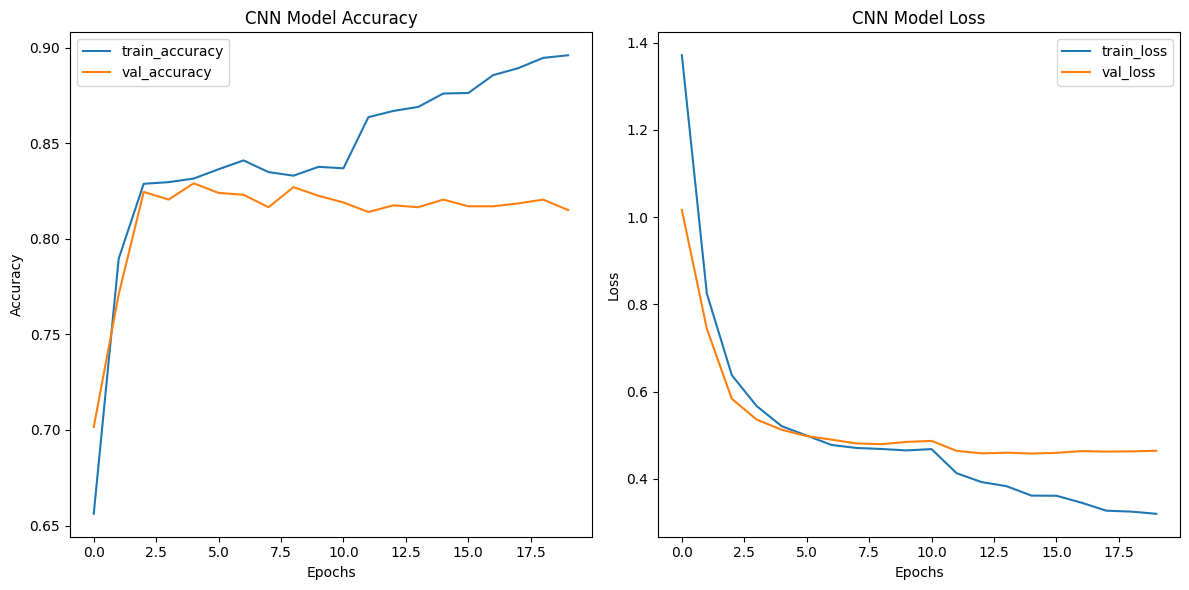

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8182 - loss: 0.4612
CNN Model Test Accuracy: 0.8205


In [42]:
# 2. 建模 - 使用 CNN
# 2a. 改进后的 CNN 模型
cnn_model = Sequential()
cnn_model.add(Dense(64, activation='relu', input_shape=(X_train_tfidf.shape[1],), kernel_regularizer=regularizers.l2(0.01)))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.6))
cnn_model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.6))
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])

# 設置提早停止回調和學習率減少回調
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)

# 將模型移動到 GPU
with tf.device('/GPU:0'):
    cnn_history = cnn_model.fit(X_train_tfidf, y_train, epochs=30, validation_data=(X_test_tfidf, y_test), batch_size=32, callbacks=[early_stopping, reduce_lr])

# 2c. 繪製訓練過程中的 Accuracy 和 Loss
plt.figure(figsize=(12, 6))

# CNN Accuracy
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='train_accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='val_accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# CNN Loss
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='train_loss')
plt.plot(cnn_history.history['val_loss'], label='val_loss')
plt.title('CNN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 3. 評估模型
# 3a. 利用測試資料計算模型的準確率
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(X_test_tfidf, y_test)
print(f'CNN Model Test Accuracy: {cnn_test_accuracy:.4f}')

c:\Users\User\anaconda3\envs\DataMining\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5573 - loss: 1.2200 - val_accuracy: 0.7015 - val_loss: 0.8963 - learning_rate: 0.0010
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7252 - loss: 0.8744 - val_accuracy: 0.7645 - val_loss: 0.7939 - learning_rate: 0.0010
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8283 - loss: 0.7268 - val_accuracy: 0.8290 - val_loss: 0.7005 - learning_rate: 0.0010
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8705 - loss: 0.6428 - val_accuracy: 0.8310 - val_loss: 0.7030 - learning_rate: 0.0010
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8972 - loss: 0.5661 - val_accuracy: 0.8285 - val_loss: 0.7222 - learning_rate: 0.0010
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9154 - loss: 0.5140 - val_accuracy: 0.8125 - val_loss: 0.7405 - learning_rate: 0.0010
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9303 - loss: 0.4673 - 

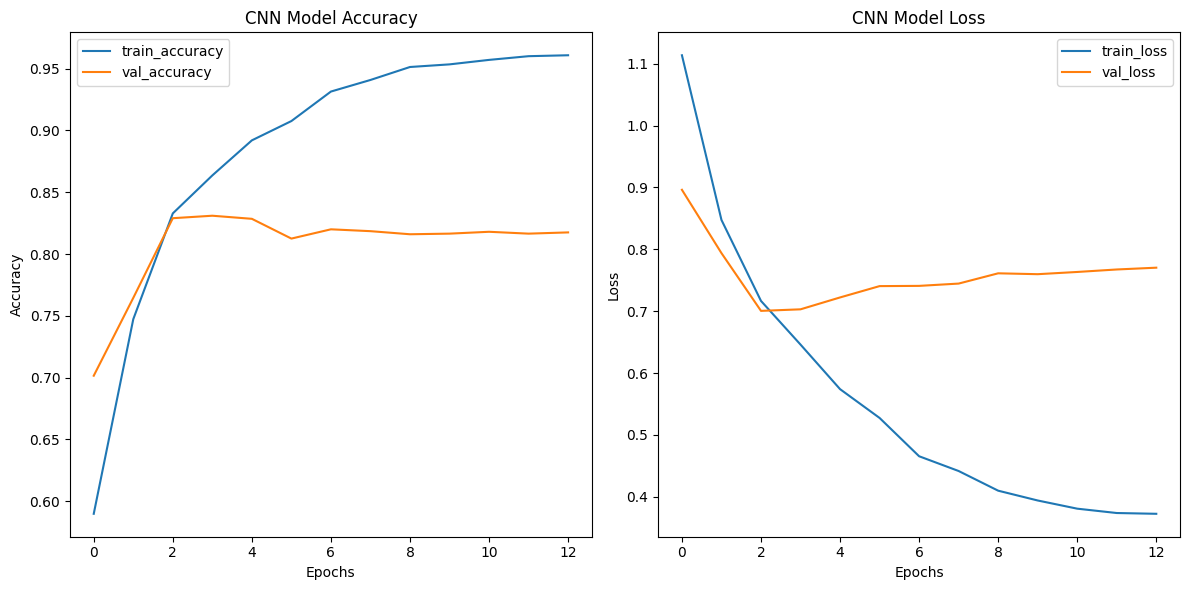

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8242 - loss: 0.7127
CNN Model Test Accuracy: 0.8290


In [7]:
cnn_model = Sequential()
cnn_model.add(Dense(128, activation='relu', input_shape=(X_train_tfidf.shape[1],), kernel_regularizer=regularizers.l2(0.001)))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.7))
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

# 更新回调函数
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

with tf.device('/GPU:0'):
    cnn_history = cnn_model.fit(X_train_tfidf, y_train, epochs=50, validation_data=(X_test_tfidf, y_test), batch_size=32, callbacks=[early_stopping, reduce_lr])

# 2c. 繪製訓練過程中的 Accuracy 和 Loss
plt.figure(figsize=(12, 6))

# CNN Accuracy
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='train_accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='val_accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# CNN Loss
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='train_loss')
plt.plot(cnn_history.history['val_loss'], label='val_loss')
plt.title('CNN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 3. 評估模型
# 3a. 利用測試資料計算模型的準確率
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(X_test_tfidf, y_test)
print(f'CNN Model Test Accuracy: {cnn_test_accuracy:.4f}')


Epoch 1/50


250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5143 - loss: 3.2236 - val_accuracy: 0.7015 - val_loss: 2.2454 - learning_rate: 1.0000e-04
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5322 - loss: 2.9807 - val_accuracy: 0.7015 - val_loss: 2.1960 - learning_rate: 1.0000e-04
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5585 - loss: 2.8328 - val_accuracy: 0.6980 - val_loss: 2.1478 - learning_rate: 1.0000e-04
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5597 - loss: 2.7143 - val_accuracy: 0.7070 - val_loss: 2.0980 - learning_rate: 1.0000e-04
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5738 - loss: 2.6447 - val_accuracy: 0.7120 - val_loss: 2.0518 - learning_rate: 1.0000e-04
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5925 - loss: 2.5428 - val_accuracy: 0.7245 - val_loss: 2.0080 - learning_rate: 1.0000e-04
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6057 - lo

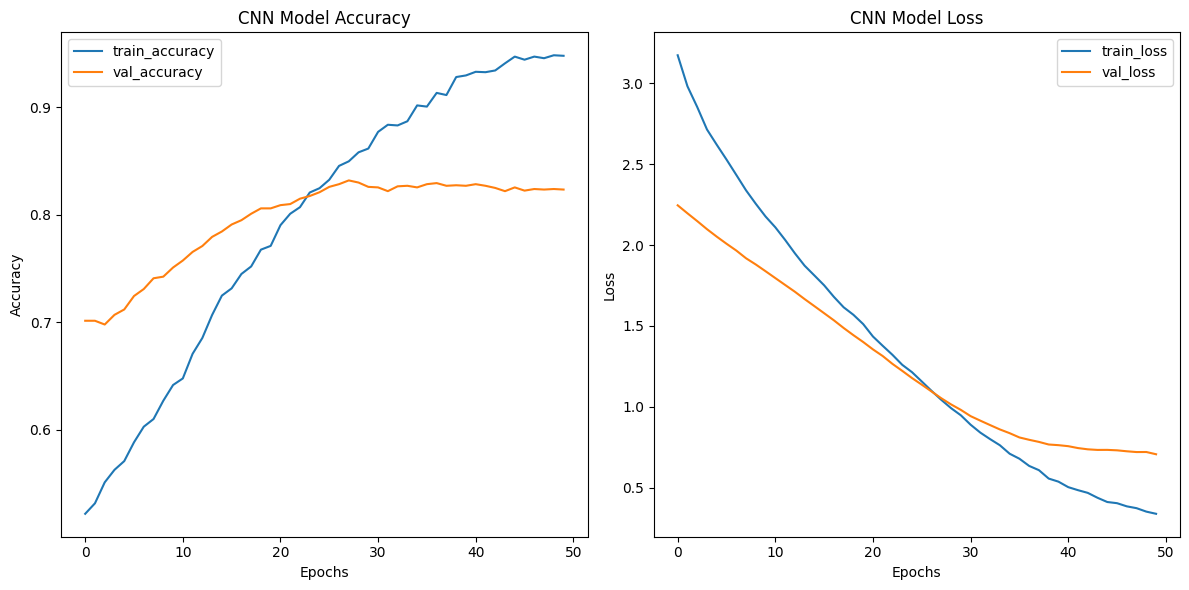

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8261 - loss: 0.6928
CNN Model Test Accuracy: 0.8235


In [14]:
cnn_model = Sequential()
cnn_model.add(Dense(64, activation='relu', input_shape=(X_train_tfidf.shape[1],), kernel_regularizer=regularizers.l2(0.01)))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.8))
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 更新回调函数
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

# 训练模型
with tf.device('/GPU:0'):
    cnn_history = cnn_model.fit(X_train_tfidf, y_train, epochs=50, validation_data=(X_test_tfidf, y_test), batch_size=32, callbacks=[early_stopping, reduce_lr])

# 绘制训练过程中的 Accuracy 和 Loss
plt.figure(figsize=(12, 6))

# CNN Accuracy
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='train_accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='val_accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# CNN Loss
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='train_loss')
plt.plot(cnn_history.history['val_loss'], label='val_loss')
plt.title('CNN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 评估模型
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(X_test_tfidf, y_test)
print(f'CNN Model Test Accuracy: {cnn_test_accuracy:.4f}')


TF-IDF + LSTM

Using device: cuda
Epoch 1/50


c:\Users\User\anaconda3\envs\DataMining\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.7061 - loss: 0.5873 - val_accuracy: 0.8090 - val_loss: 0.4294 - learning_rate: 0.0010
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.8725 - loss: 0.3248 - val_accuracy: 0.8185 - val_loss: 0.4355 - learning_rate: 0.0010
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9073 - loss: 0.2462 - val_accuracy: 0.7790 - val_loss: 0.5112 - learning_rate: 0.0010
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.9276 - loss: 0.1764 - val_accuracy: 0.8150 - val_loss: 0.6081 - learning_rate: 2.0000e-04
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.9606 - loss: 0.1164 - val_accuracy: 0.8065 - val_loss: 0.6928 - learning_rate: 2.0000e-04
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.9734 - loss: 0.0844 - val_accuracy: 0.8085 - val_loss: 0.6972 - learning_rate: 4.0000e-05


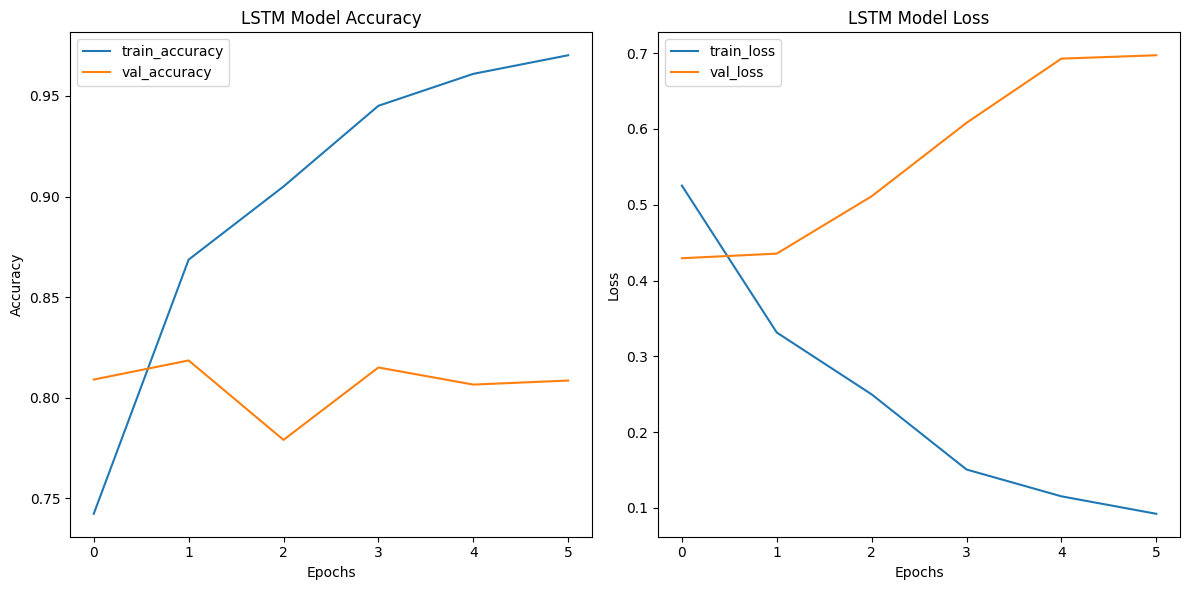

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8035 - loss: 0.4361
LSTM Model Test Accuracy: 0.8090


In [66]:
# 設定使用 GPU 加速 (CUDA)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

# 1.1 讀取資料並保留"text"和"stars"兩個欄位
df = pd.read_csv('yelp.csv', usecols=['text', 'stars'])

# 將stars欄位的值大於等於4的轉成1，其餘轉成0
df['stars'] = df['stars'].apply(lambda x: 1 if x >= 4 else 0)

# 將"text"欄位內的文字利用正則表達式移除標點符號和非字母字符，並轉為小寫
df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x).lower())

# 切分資料為80%訓練集和20%測試集
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# 1.2 去除停頓詞
def remove_stop_words(text):
    words = text.split()
    filtered_words = [word for word in words if word not in ENGLISH_STOP_WORDS]
    return ' '.join(filtered_words)

train_df['text'] = train_df['text'].apply(remove_stop_words)
test_df['text'] = test_df['text'].apply(remove_stop_words)

# 1.3 文字探勘前處理 - Tokenizer 和填充序列
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_df['text'])
X_train_seq = tokenizer.texts_to_sequences(train_df['text'])
X_test_seq = tokenizer.texts_to_sequences(test_df['text'])

X_train_pad = pad_sequences(X_train_seq, maxlen=100, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=100, padding='post')

y_train = train_df['stars'].values
y_test = test_df['stars'].values

# 2. 建模 - 使用 LSTM
# 2a. LSTM 模型
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=5000, output_dim=100, input_length=100))
lstm_model.add(Bidirectional(LSTM(128, return_sequences=False)))
lstm_model.add(Dropout(0.7))
lstm_model.add(Dense(64, activation='relu'))
# lstm_model.add(Dropout(0.7))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 設置提早停止回調和學習率減少回調
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)

# 將模型移動到 GPU
with tf.device('/GPU:0'):
    lstm_history = lstm_model.fit(X_train_pad, y_train, epochs=50, validation_data=(X_test_pad, y_test), batch_size=32, callbacks=[early_stopping, reduce_lr])

# 2c. 繪製訓練過程中的 Accuracy 和 Loss
plt.figure(figsize=(12, 6))

# LSTM Accuracy
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['accuracy'], label='train_accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='val_accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# LSTM Loss
plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'], label='train_loss')
plt.plot(lstm_history.history['val_loss'], label='val_loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 3. 評估模型
# 3a. 利用測試資料計算模型的準確率
lstm_test_loss, lstm_test_accuracy = lstm_model.evaluate(X_test_pad, y_test)
print(f'LSTM Model Test Accuracy: {lstm_test_accuracy:.4f}')


Using device: cuda
Epoch 1/50


c:\Users\User\anaconda3\envs\DataMining\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.7042 - loss: 0.5966 - val_accuracy: 0.7945 - val_loss: 0.4597 - learning_rate: 0.0010
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.8663 - loss: 0.3523 - val_accuracy: 0.8225 - val_loss: 0.4534 - learning_rate: 0.0010
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.9099 - loss: 0.2546 - val_accuracy: 0.8075 - val_loss: 0.4766 - learning_rate: 0.0010
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.9403 - loss: 0.1719 - val_accuracy: 0.7990 - val_loss: 0.6027 - learning_rate: 0.0010
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.9642 - loss: 0.1066 - val_accuracy: 0.7965 - val_loss: 0.7156 - learning_rate: 2.0000e-04
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.9798 - loss: 0.0745 - val_accuracy: 0.8010 - val_loss: 0.9040 - learning_rate: 2.0000e-04
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.9851 - loss

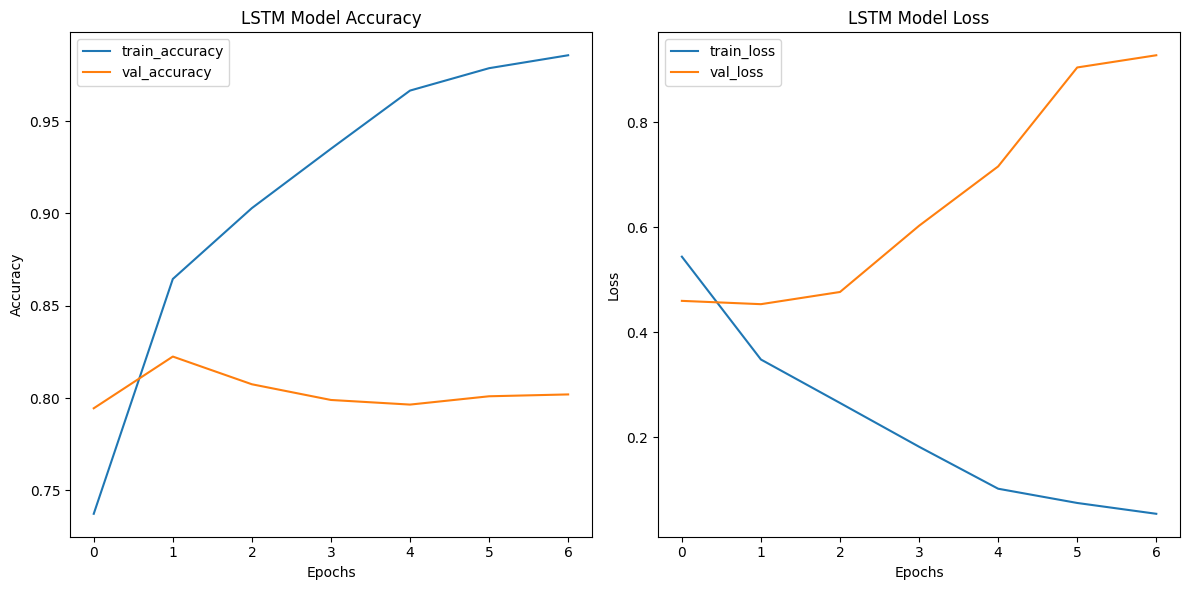

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8144 - loss: 0.4678
LSTM Model Test Accuracy: 0.8225


In [ ]:
# 設定使用 GPU 加速 (CUDA)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

# 1.1 讀取資料並保留"text"和"stars"兩個欄位
df = pd.read_csv('yelp.csv', usecols=['text', 'stars'])

# 將stars欄位的值大於等於4的轉成1，其餘轉成0
df['stars'] = df['stars'].apply(lambda x: 1 if x >= 4 else 0)

# 將"text"欄位內的文字利用正則表達式移除標點符號和非字母字符，並轉為小寫
df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x).lower())

# 切分資料為80%訓練集和20%測試集
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# 1.2 去除停頓詞
def remove_stop_words(text):
    words = text.split()
    filtered_words = [word for word in words if word not in ENGLISH_STOP_WORDS]
    return ' '.join(filtered_words)

train_df['text'] = train_df['text'].apply(remove_stop_words)
test_df['text'] = test_df['text'].apply(remove_stop_words)

# 1.3 文字探勘前處理 - Tokenizer 和填充序列
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_df['text'])
X_train_seq = tokenizer.texts_to_sequences(train_df['text'])
X_test_seq = tokenizer.texts_to_sequences(test_df['text'])

X_train_pad = pad_sequences(X_train_seq, maxlen=100, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=100, padding='post')

y_train = train_df['stars'].values
y_test = test_df['stars'].values

# 2. 建模 - 使用 LSTM
# 2a. LSTM 模型
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=5000, output_dim=100, input_length=100))
lstm_model.add(Bidirectional(LSTM(128, return_sequences=False)))
# lstm_model.add(Dropout(0.7))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dropout(0.7))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 設置提早停止回調和學習率減少回調
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)

# 將模型移動到 GPU
with tf.device('/GPU:0'):
    lstm_history = lstm_model.fit(X_train_pad, y_train, epochs=50, validation_data=(X_test_pad, y_test), batch_size=32, callbacks=[early_stopping, reduce_lr])

# 2c. 繪製訓練過程中的 Accuracy 和 Loss
plt.figure(figsize=(12, 6))

# LSTM Accuracy
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['accuracy'], label='train_accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='val_accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# LSTM Loss
plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'], label='train_loss')
plt.plot(lstm_history.history['val_loss'], label='val_loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 3. 評估模型
# 3a. 利用測試資料計算模型的準確率
lstm_test_loss, lstm_test_accuracy = lstm_model.evaluate(X_test_pad, y_test)
print(f'LSTM Model Test Accuracy: {lstm_test_accuracy:.4f}')


Using device: cuda
Epoch 1/30


c:\Users\User\anaconda3\envs\DataMining\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.6822 - loss: 1.2012 - val_accuracy: 0.7800 - val_loss: 0.5222 - learning_rate: 0.0010
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.8437 - loss: 0.4194 - val_accuracy: 0.8215 - val_loss: 0.4218 - learning_rate: 0.0010
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.9068 - loss: 0.2748 - val_accuracy: 0.8150 - val_loss: 0.4741 - learning_rate: 0.0010
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.9270 - loss: 0.2230 - val_accuracy: 0.8010 - val_loss: 0.5424 - learning_rate: 0.0010
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.9527 - loss: 0.1653 - val_accuracy: 0.8085 - val_loss: 0.6092 - learning_rate: 2.0000e-04


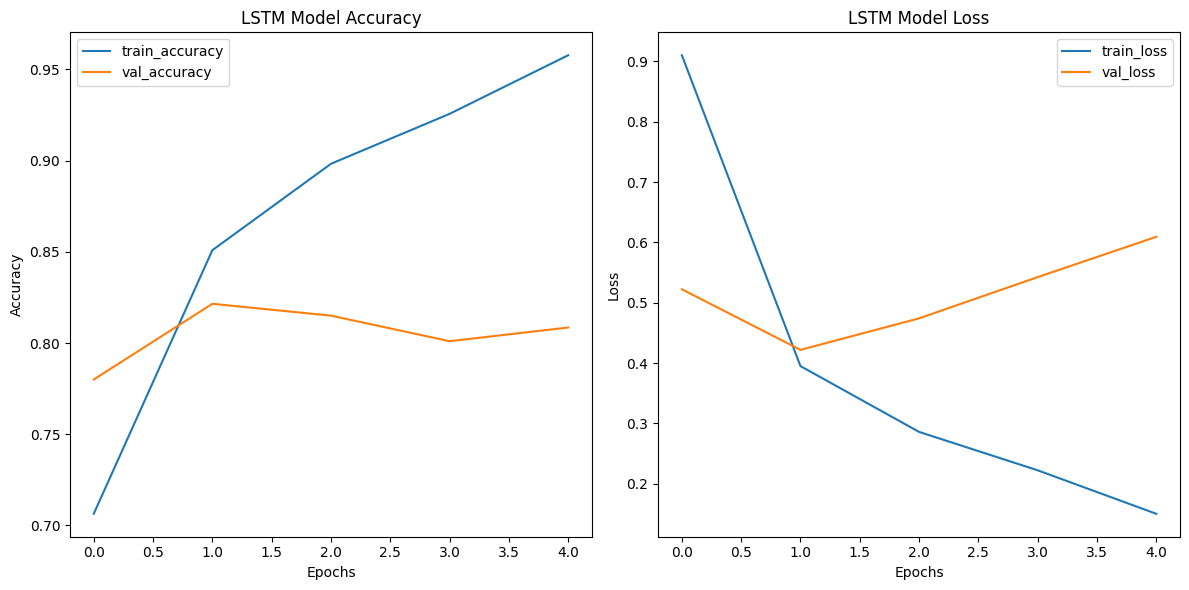

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8152 - loss: 0.4320
LSTM Model Test Accuracy: 0.8215


In [18]:
# 設定使用 GPU 加速 (CUDA)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

# 1.1 讀取資料並保留"text"和"stars"兩個欄位
df = pd.read_csv('yelp.csv', usecols=['text', 'stars'])

# 將stars欄位的值大於等於4的轉成1，其餘轉成0
df['stars'] = df['stars'].apply(lambda x: 1 if x >= 4 else 0)

# 將"text"欄位內的文字利用正則表達式移除標點符號和非字母字符，並轉為小寫
df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x).lower())

# 切分資料為80%訓練集和20%測試集
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# 1.2 去除停頓詞
def remove_stop_words(text):
    words = text.split()
    filtered_words = [word for word in words if word not in ENGLISH_STOP_WORDS]
    return ' '.join(filtered_words)

train_df['text'] = train_df['text'].apply(remove_stop_words)
test_df['text'] = test_df['text'].apply(remove_stop_words)

# 1.3 文字探勘前處理 - Tokenizer 和填充序列
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_df['text'])
X_train_seq = tokenizer.texts_to_sequences(train_df['text'])
X_test_seq = tokenizer.texts_to_sequences(test_df['text'])

X_train_pad = pad_sequences(X_train_seq, maxlen=100, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=100, padding='post')

y_train = train_df['stars'].values
y_test = test_df['stars'].values

# 2. 建模 - 使用 LSTM
# 2a. LSTM 模型
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=10000, output_dim=128, input_length=200))
lstm_model.add(Bidirectional(LSTM(128, return_sequences=False)))
lstm_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 設置提早停止回調和學習率減少回調
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)

# 將模型移動到 GPU
with tf.device('/GPU:0'):
    lstm_history = lstm_model.fit(X_train_pad, y_train, epochs=30, validation_data=(X_test_pad, y_test), batch_size=64, callbacks=[early_stopping, reduce_lr])

# 2c. 繪製訓練過程中的 Accuracy 和 Loss
plt.figure(figsize=(12, 6))

# LSTM Accuracy
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['accuracy'], label='train_accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='val_accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# LSTM Loss
plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'], label='train_loss')
plt.plot(lstm_history.history['val_loss'], label='val_loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 3. 評估模型
# 3a. 利用測試資料計算模型的準確率
lstm_test_loss, lstm_test_accuracy = lstm_model.evaluate(X_test_pad, y_test)
print(f'LSTM Model Test Accuracy: {lstm_test_accuracy:.4f}')

Using device: cuda


c:\Users\User\anaconda3\envs\DataMining\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.6953 - loss: 0.5787 - val_accuracy: 0.8360 - val_loss: 0.3918 - learning_rate: 0.0010
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9055 - loss: 0.2369 - val_accuracy: 0.8205 - val_loss: 0.4230 - learning_rate: 0.0010
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9647 - loss: 0.1095 - val_accuracy: 0.8165 - val_loss: 0.5770 - learning_rate: 0.0010
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9884 - loss: 0.0427 - val_accuracy: 0.8015 - val_loss: 0.7498 - learning_rate: 0.0010
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.9965 - loss: 0.0148 - val_accuracy: 0.8015 - val_loss: 0.7830 - learning_rate: 2.0000e-04
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9976 - loss: 0.0121 - val_accuracy: 0.7990 - val_loss: 0.8173 - learning_rate: 2.0000e-04


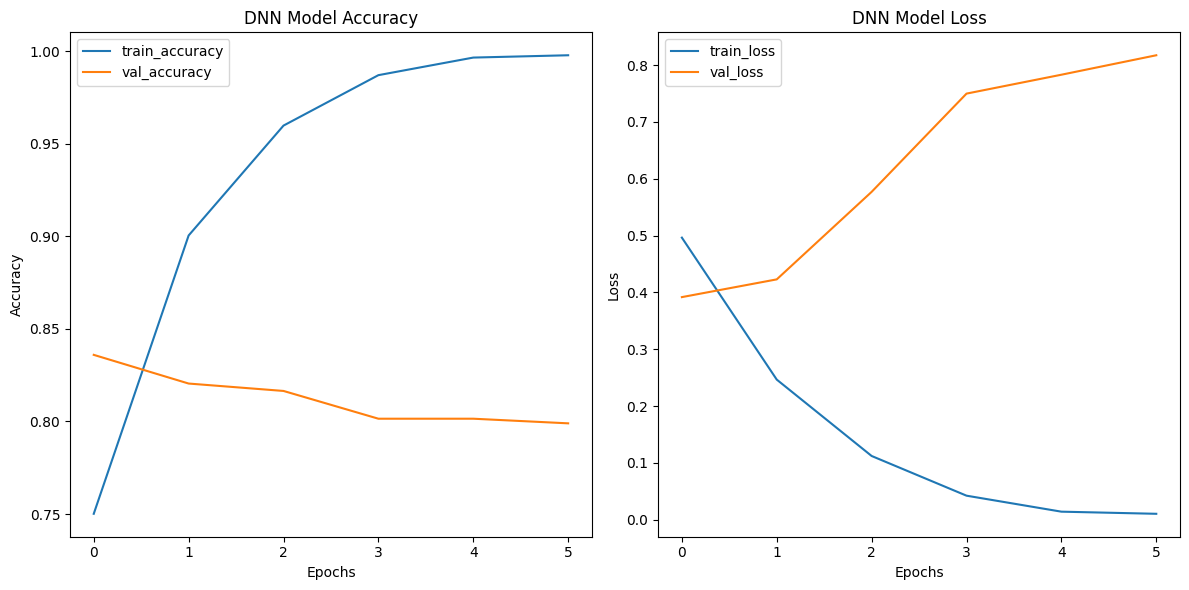

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8373 - loss: 0.3974
DNN Model Test Accuracy: 0.8360


In [ ]:
# 設定使用 GPU 加速 (CUDA)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

# 1.1 讀取資料並保留"text"和"stars"兩個欄位
df = pd.read_csv('yelp.csv', usecols=['text', 'stars'])

# 將stars欄位的值大於等於4的轉成1，其餘轉成0
df['stars'] = df['stars'].apply(lambda x: 1 if x >= 4 else 0)

# 1.2 使用TF-IDF進行文本向量化
# 將"text"欄位內的文字利用正則表達式移除標點符號和非字母字符，並轉為小寫
df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x).lower())

# 切分資料為80%訓練集和20%測試集
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# 去除停頓詞
def remove_stop_words(text):
    words = text.split()
    filtered_words = [word for word in words if word not in ENGLISH_STOP_WORDS]
    return ' '.join(filtered_words)

train_df['text'] = train_df['text'].apply(remove_stop_words)
test_df['text'] = test_df['text'].apply(remove_stop_words)

# 使用 TF-IDF 向量化文本
tfidf = TfidfVectorizer(max_features=15000)
X_train_tfidf = tfidf.fit_transform(train_df['text']).toarray()
X_test_tfidf = tfidf.transform(test_df['text']).toarray()

y_train = train_df['stars'].values
y_test = test_df['stars'].values

# 2. 建模 - 使用全連接神經網路 (DNN)
# 2a. DNN 模型
dnn_model = Sequential()
dnn_model.add(Dense(512, activation='relu', input_shape=(X_train_tfidf.shape[1],)))
dnn_model.add(Dropout(0.7))
dnn_model.add(Dense(256, activation='relu'))
dnn_model.add(Dropout(0.5))
dnn_model.add(Dense(1, activation='sigmoid'))

dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 設置提早停止回調和學習率減少回調
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# 將模型移動到 GPU
with tf.device('/GPU:0'):
    dnn_history = dnn_model.fit(X_train_tfidf, y_train, epochs=50, validation_data=(X_test_tfidf, y_test), batch_size=64, callbacks=[early_stopping, reduce_lr])

# 2c. 繪製訓練過程中的 Accuracy 和 Loss
plt.figure(figsize=(12, 6))

# DNN Accuracy
plt.subplot(1, 2, 1)
plt.plot(dnn_history.history['accuracy'], label='train_accuracy')
plt.plot(dnn_history.history['val_accuracy'], label='val_accuracy')
plt.title('DNN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# DNN Loss
plt.subplot(1, 2, 2)
plt.plot(dnn_history.history['loss'], label='train_loss')
plt.plot(dnn_history.history['val_loss'], label='val_loss')
plt.title('DNN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 3. 評估模型
# 3a. 利用測試資料計算模型的準確率
dnn_test_loss, dnn_test_accuracy = dnn_model.evaluate(X_test_tfidf, y_test)
print(f'DNN Model Test Accuracy: {dnn_test_accuracy:.4f}')


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5016 - loss: 6.2509 - val_accuracy: 0.7015 - val_loss: 4.5495 - learning_rate: 1.0000e-04
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5835 - loss: 4.5125 - val_accuracy: 0.7145 - val_loss: 3.9024 - learning_rate: 1.0000e-04
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6289 - loss: 3.9157 - val_accuracy: 0.7755 - val_loss: 3.4127 - learning_rate: 1.0000e-04
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6868 - loss: 3.4260 - val_accuracy: 0.7935 - val_loss: 3.0248 - learning_rate: 1.0000e-04
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7190 - loss: 3.0571 - val_accuracy: 0.8130 - val_loss: 2.7144 - learning_rate: 1.0000e-04
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7653 - loss: 2.7218 - val_accuracy: 0.8230 - val_loss: 2.4463 - learning_rate: 1.0000e-04
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 

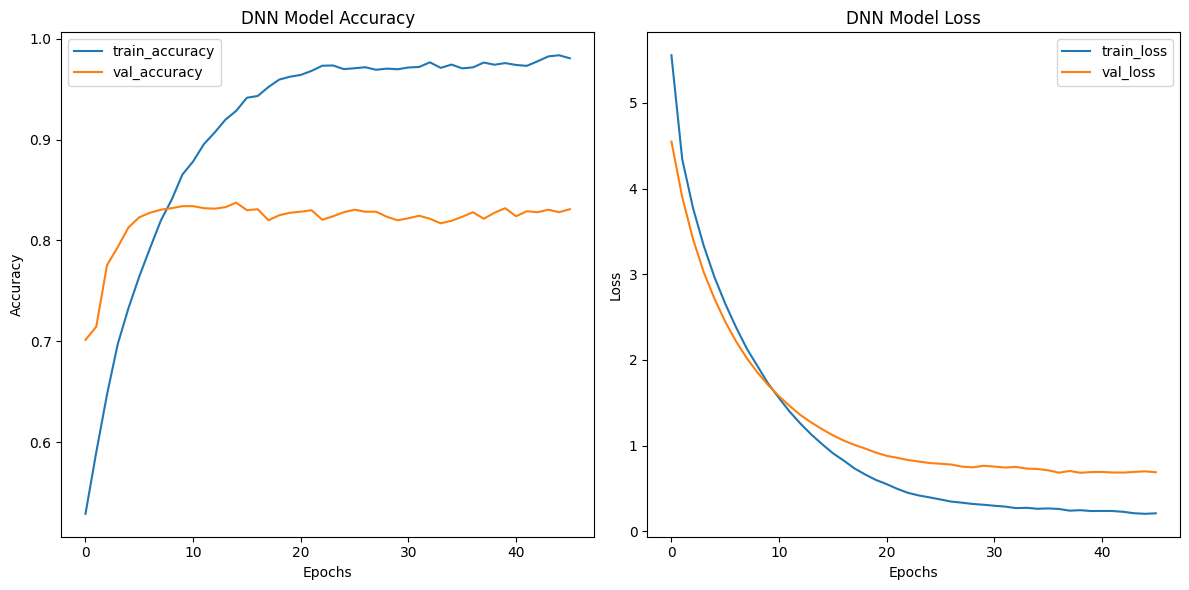

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8306 - loss: 0.6913
DNN Model Test Accuracy: 0.8275


In [20]:
# 2a. DNN 模型 - 修改後
dnn_model = Sequential()
dnn_model.add(Dense(256, activation='relu', input_shape=(X_train_tfidf.shape[1],), kernel_regularizer=regularizers.l2(0.01)))
dnn_model.add(Dropout(0.7))
dnn_model.add(BatchNormalization())
dnn_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
dnn_model.add(Dropout(0.7))
dnn_model.add(BatchNormalization())
dnn_model.add(Dense(1, activation='sigmoid'))

dnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# 設置提早停止回調和學習率減少回調
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# 將模型移動到 GPU
with tf.device('/GPU:0'):
    dnn_history = dnn_model.fit(X_train_tfidf, y_train, epochs=50, validation_data=(X_test_tfidf, y_test), batch_size=32, callbacks=[early_stopping, reduce_lr])

# 2c. 繪製訓練過程中的 Accuracy 和 Loss
plt.figure(figsize=(12, 6))

# DNN Accuracy
plt.subplot(1, 2, 1)
plt.plot(dnn_history.history['accuracy'], label='train_accuracy')
plt.plot(dnn_history.history['val_accuracy'], label='val_accuracy')
plt.title('DNN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# DNN Loss
plt.subplot(1, 2, 2)
plt.plot(dnn_history.history['loss'], label='train_loss')
plt.plot(dnn_history.history['val_loss'], label='val_loss')
plt.title('DNN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 3. 評估模型
# 3a. 利用測試資料計算模型的準確率
dnn_test_loss, dnn_test_accuracy = dnn_model.evaluate(X_test_tfidf, y_test)
print(f'DNN Model Test Accuracy: {dnn_test_accuracy:.4f}')


Using device: cuda


c:\Users\User\anaconda3\envs\DataMining\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7235 - loss: 0.5479 - val_accuracy: 0.8345 - val_loss: 0.3777 - learning_rate: 0.0010
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8938 - loss: 0.2631 - val_accuracy: 0.8350 - val_loss: 0.3932 - learning_rate: 0.0010
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.9507 - loss: 0.1450 - val_accuracy: 0.8165 - val_loss: 0.5009 - learning_rate: 0.0010
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9816 - loss: 0.0692 - val_accuracy: 0.8115 - val_loss: 0.5879 - learning_rate: 2.0000e-04
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9904 - loss: 0.0418 - val_accuracy: 0.8145 - val_loss: 0.6440 - learning_rate: 2.0000e-04
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9943 - loss: 0.0285 - val_accuracy: 0.8135 - val_loss: 0.6582 - learning_rate: 4.0000e-05


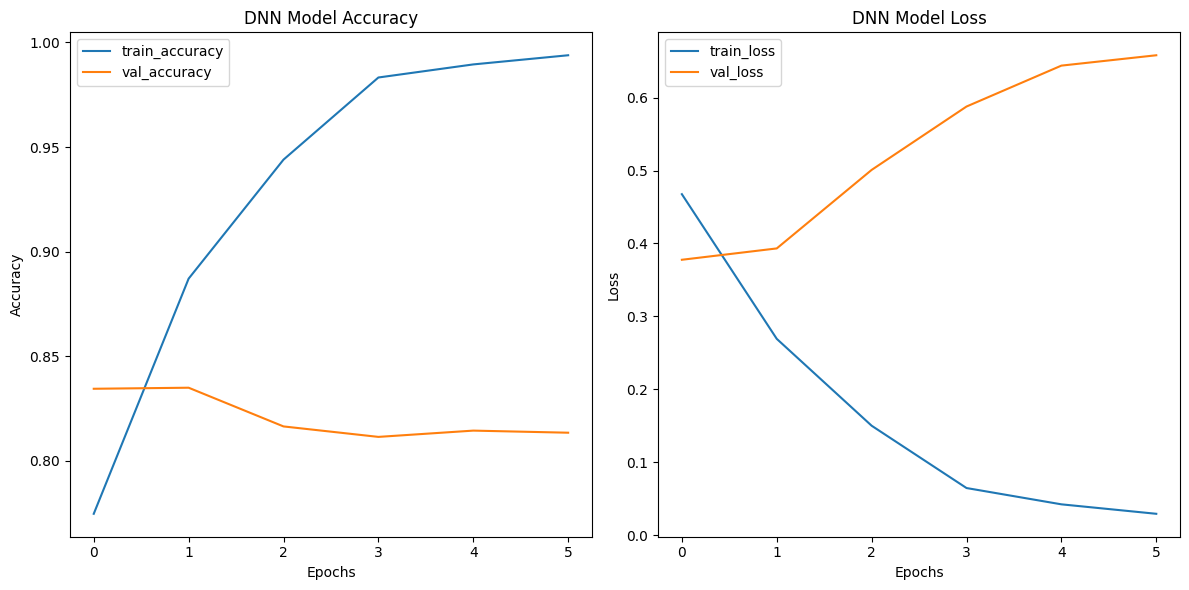

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8250 - loss: 0.3986
DNN Model Test Accuracy: 0.8345


In [49]:
# 設定使用 GPU 加速 (CUDA)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

# 1.1 讀取資料並保留"text"和"stars"兩個欄位
df = pd.read_csv('yelp.csv', usecols=['text', 'stars'])

# 將stars欄位的值大於等於4的轉成1，其餘轉成0
df['stars'] = df['stars'].apply(lambda x: 1 if x >= 4 else 0)

# 將"text"欄位內的文字利用正則表達式移除標點符號和非字母字符，並轉為小寫
df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x).lower())

# 切分資料為80%訓練集和20%測試集
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# 1.2 去除停頓詞
def remove_stop_words(text):
    words = text.split()
    filtered_words = [word for word in words if word not in ENGLISH_STOP_WORDS]
    return ' '.join(filtered_words)

train_df['text'] = train_df['text'].apply(remove_stop_words)
test_df['text'] = test_df['text'].apply(remove_stop_words)

# 1.3 文字探勘前處理 - TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(train_df['text']).toarray()
X_test_tfidf = tfidf.transform(test_df['text']).toarray()

y_train = train_df['stars'].values
y_test = test_df['stars'].values

# 2. 建模 - 使用全連接神經網路 (DNN)
# 2a. DNN 模型
dnn_model = Sequential()
dnn_model.add(Dense(512, activation='relu', input_shape=(X_train_tfidf.shape[1],)))
dnn_model.add(Dropout(0.5))
dnn_model.add(Dense(256, activation='relu'))
dnn_model.add(Dropout(0.5))
dnn_model.add(Dense(1, activation='sigmoid'))

dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 設置提早停止回調和學習率減少回調
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)

# 將模型移動到 GPU
with tf.device('/GPU:0'):
    dnn_history = dnn_model.fit(X_train_tfidf, y_train, epochs=50, validation_data=(X_test_tfidf, y_test), batch_size=32, callbacks=[early_stopping, reduce_lr])

# 2c. 繪製訓練過程中的 Accuracy 和 Loss
plt.figure(figsize=(12, 6))

# DNN Accuracy
plt.subplot(1, 2, 1)
plt.plot(dnn_history.history['accuracy'], label='train_accuracy')
plt.plot(dnn_history.history['val_accuracy'], label='val_accuracy')
plt.title('DNN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# DNN Loss
plt.subplot(1, 2, 2)
plt.plot(dnn_history.history['loss'], label='train_loss')
plt.plot(dnn_history.history['val_loss'], label='val_loss')
plt.title('DNN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 3. 評估模型
# 3a. 利用測試資料計算模型的準確率
dnn_test_loss, dnn_test_accuracy = dnn_model.evaluate(X_test_tfidf, y_test)
print(f'DNN Model Test Accuracy: {dnn_test_accuracy:.4f}')


Word2Vec + CNN

In [21]:
# 設定使用 GPU 加速 (CUDA)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')



# 1.1 讀取資料並保留"text"和"stars"兩個欄位
df = pd.read_csv('yelp.csv', usecols=['text', 'stars'])

# 將stars欄位的值大於等於4的轉成1，其餘轉成0
df['stars'] = df['stars'].apply(lambda x: 1 if x >= 4 else 0)

# 將"text"欄位內的文字利用分割符號切割
df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x).lower())

# 切分資料為80%訓練集和20%測試集
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# 1.2 去除停頓詞
def remove_stop_words(text):
    words = text.split()
    filtered_words = [word for word in words if word not in ENGLISH_STOP_WORDS]
    return ' '.join(filtered_words)

train_df['text'] = train_df['text'].apply(remove_stop_words)
test_df['text'] = test_df['text'].apply(remove_stop_words)

# 1.3 文字探勘前處理 - Word2Vec
train_sentences = [text.split() for text in train_df['text']]
test_sentences = [text.split() for text in test_df['text']]

# 訓練 Word2Vec 模型
word2vec_model = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=2, workers=4)

# 將每個評論轉換成向量的平均值
def get_word2vec_vectors(sentences, model):
    vectors = []
    for sentence in sentences:
        vec = [model.wv[word] for word in sentence if word in model.wv]
        if len(vec) > 0:
            vectors.append(sum(vec) / len(vec))
        else:
            vectors.append([0] * model.vector_size)
    return vectors

X_train_w2v = np.array(get_word2vec_vectors(train_sentences, word2vec_model))
X_test_w2v = np.array(get_word2vec_vectors(test_sentences, word2vec_model))

y_train = train_df['stars'].values
y_test = test_df['stars'].values

Using device: cuda


c:\Users\User\anaconda3\envs\DataMining\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5782 - loss: 1.8675 - val_accuracy: 0.7030 - val_loss: 1.0589 - learning_rate: 0.0010
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7766 - loss: 0.9236 - val_accuracy: 0.7765 - val_loss: 0.7682 - learning_rate: 0.0010
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8224 - loss: 0.6869 - val_accuracy: 0.8205 - val_loss: 0.6158 - learning_rate: 0.0010
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8431 - loss: 0.5864 - val_accuracy: 0.8110 - val_loss: 0.5671 - learning_rate: 0.0010
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8420 - loss: 0.5258 - val_accuracy: 0.8215 - val_loss: 0.5221 - learning_rate: 0.0010
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8479 - loss: 0.4841 - val_accuracy: 0.8175 - val_loss: 0.5108 - learning_rate: 0.0010
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8412 - loss: 0.4809 - 

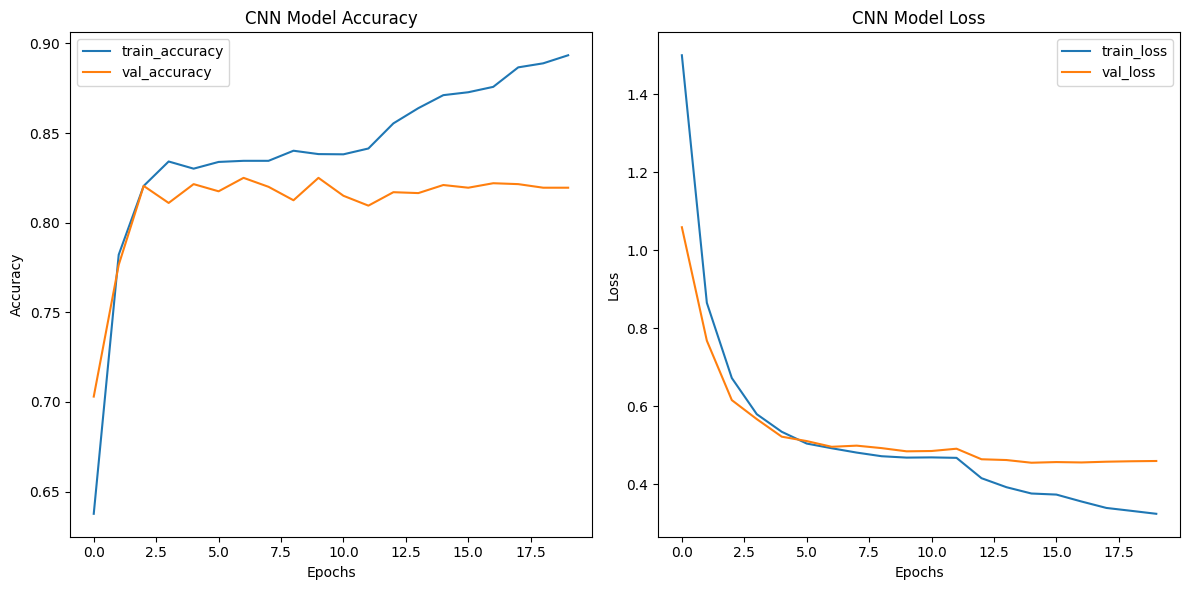

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8192 - loss: 0.4635 
CNN Model Test Accuracy: 0.8210


In [22]:
# 2. 建模 - 使用 CNN
# 2a. 改进后的 CNN 模型
cnn_model = Sequential()
cnn_model.add(Dense(64, activation='relu', input_shape=(X_train_tfidf.shape[1],), kernel_regularizer=regularizers.l2(0.01)))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.6))
cnn_model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.6))
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])

# 設置提早停止回調和學習率減少回調
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)

# 將模型移動到 GPU
with tf.device('/GPU:0'):
    cnn_history = cnn_model.fit(X_train_tfidf, y_train, epochs=30, validation_data=(X_test_tfidf, y_test), batch_size=32, callbacks=[early_stopping, reduce_lr])

# 2c. 繪製訓練過程中的 Accuracy 和 Loss
plt.figure(figsize=(12, 6))

# CNN Accuracy
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='train_accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='val_accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# CNN Loss
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='train_loss')
plt.plot(cnn_history.history['val_loss'], label='val_loss')
plt.title('CNN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 3. 評估模型
# 3a. 利用測試資料計算模型的準確率
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(X_test_tfidf, y_test)
print(f'CNN Model Test Accuracy: {cnn_test_accuracy:.4f}')

Word2Vec + LSTM

Using device: cuda
Epoch 1/50


c:\Users\User\anaconda3\envs\DataMining\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.6716 - loss: 1.2885 - val_accuracy: 0.7110 - val_loss: 0.6762 - learning_rate: 0.0010
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.7461 - loss: 0.6251 - val_accuracy: 0.7365 - val_loss: 0.5415 - learning_rate: 0.0010
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.7715 - loss: 0.5301 - val_accuracy: 0.7660 - val_loss: 0.5143 - learning_rate: 0.0010
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.7818 - loss: 0.5027 - val_accuracy: 0.7595 - val_loss: 0.5165 - learning_rate: 0.0010
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.7730 - loss: 0.5142 - val_accuracy: 0.7710 - val_loss: 0.4877 - learning_rate: 0.0010
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.7775 - loss: 0.4947 - val_accuracy: 0.7735 - val_loss: 0.4866 - learning_rate: 0.0010
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.7841 - loss: 0.4838 - val

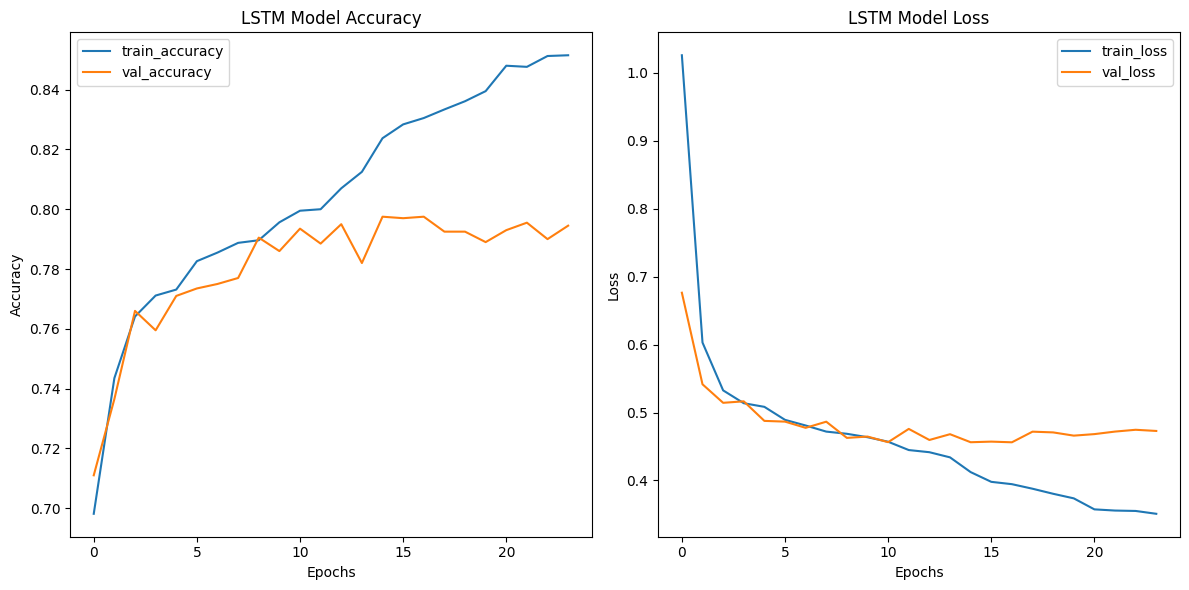

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8033 - loss: 0.4605
LSTM Model Test Accuracy: 0.7975


In [28]:
# 設定使用 GPU 加速 (CUDA)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

# 1.1 讀取資料並保留"text"和"stars"兩個欄位
df = pd.read_csv('yelp.csv', usecols=['text', 'stars'])

# 將stars欄位的值大於等於4的轉成1，其餘轉成0
df['stars'] = df['stars'].apply(lambda x: 1 if x >= 4 else 0)

# 將"text"欄位內的文字利用正則表達式移除標點符號和非字母字符，並轉為小寫
df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x).lower())

# 切分資料為80%訓練集和20%測試集
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# 1.2 去除停頓詞和進行詞幹化處理
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def preprocess_text(text):
    words = text.split()
    filtered_words = [stemmer.stem(word) for word in words if word not in ENGLISH_STOP_WORDS]
    return ' '.join(filtered_words)

train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

# 1.3 文字探勘前處理 - 使用 Word2Vec 進行詞向量化
from gensim.models import Word2Vec

# 訓練 Word2Vec 模型
sentences = [text.split() for text in train_df['text']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

# 將文本轉換為詞向量的平均值
def text_to_vector(text, model):
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

X_train = np.array([text_to_vector(text, word2vec_model) for text in train_df['text']])
X_test = np.array([text_to_vector(text, word2vec_model) for text in test_df['text']])

y_train = train_df['stars'].values
y_test = test_df['stars'].values

# 2. 建模 - 使用 LSTM 模型
# 2a. LSTM 模型
from tensorflow.keras.layers import Input, LSTM, Embedding, Bidirectional

# 將序列重新轉換為 LSTM 可以處理的格式
max_length = 100

# 使用 Word2Vec 模型的詞彙量和向量維度來設置嵌入層
vocab_size = len(word2vec_model.wv)
embedding_dim = word2vec_model.vector_size

def text_to_sequence(text, model):
    words = text.split()
    sequence = [model.wv.key_to_index[word] for word in words if word in model.wv]
    return sequence

X_train_seq = [text_to_sequence(text, word2vec_model) for text in train_df['text']]
X_test_seq = [text_to_sequence(text, word2vec_model) for text in test_df['text']]

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# 使用 Bidirectional LSTM 模型
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[word2vec_model.wv.vectors], input_length=max_length, trainable=False))
lstm_model.add(Bidirectional(LSTM(128, return_sequences=False)))
lstm_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
lstm_model.add(Dropout(0.7))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 設置提早停止回調和學習率減少回調
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

# 將模型移動到 GPU
with tf.device('/GPU:0'):
    lstm_history = lstm_model.fit(X_train_pad, y_train, epochs=50, validation_data=(X_test_pad, y_test), batch_size=64, callbacks=[early_stopping, reduce_lr])

# 2c. 繪製訓練過程中的 Accuracy 和 Loss
plt.figure(figsize=(12, 6))

# LSTM Accuracy
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['accuracy'], label='train_accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='val_accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# LSTM Loss
plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'], label='train_loss')
plt.plot(lstm_history.history['val_loss'], label='val_loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 3. 評估模型
# 3a. 利用測試資料計算模型的準確率
lstm_test_loss, lstm_test_accuracy = lstm_model.evaluate(X_test_pad, y_test)
print(f'LSTM Model Test Accuracy: {lstm_test_accuracy:.4f}')